In [1]:
# !pip install xgboost

In [2]:
# from google.colab import drive
# drive.mount('/gdrive')
# %cd '/gdrive/MyDrive/Colab Notebooks/WRI-Hackathon/python_scripts/training/KRS'

### Import libraries

In [3]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, RobustScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.inspection import plot_partial_dependence, permutation_importance
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import sys
import datetime
from datetime import date, timedelta
from tqdm.notebook import tqdm
import pickle

### Read Datasets

In [4]:
inflow_df = pd.read_csv('../../dataset/reservoir_dataset.csv')
inflow_df = inflow_df[inflow_df['RESERVOIR'] == 'K.R.S']
print(inflow_df.shape)
inflow_df.head()

(3308, 11)


,FLOW_DATE,RESERVOIR,PRESENT_STORAGE_TMC,RES_LEVEL_FT,INFLOW_CUSECS,OUTFLOW_CUECS,YEAR,MONTH,DATE,DAY,SEASON
27,2011-01-01,K.R.S,46.42,122.59,2029.0,2000.0,2011,1,1,0,WINTER
28,2012-01-01,K.R.S,40.97,118.33,4924.0,2488.0,2012,1,1,0,WINTER
29,2014-01-01,K.R.S,38.58,116.33,1885.0,1994.0,2014,1,1,0,WINTER
30,2015-01-01,K.R.S,43.26,120.17,1631.0,4419.0,2015,1,1,0,WINTER
31,2016-01-01,K.R.S,27.89,106,703.0,1965.0,2016,1,1,0,WINTER


In [5]:
weather_df = pd.read_csv('../../dataset/Weather/mysuru_kodagu_hassan_weather.csv')
print(weather_df.shape)
weather_df.head()

(12783, 35)


,date,city_name,temp,feels_like,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,...,heavy intensity drizzle,very heavy rain,thunderstorm with heavy rain,thunderstorm with rain,thunderstorm,proximity shower rain,thunderstorm with light rain,shower rain,light intensity shower rain,light thunderstorm
0,2010-01-01,Hassan,21.77,22.02,17.22,26.35,1013.50,77.92,2.81,89.33,...,0,0,0,0,0,0,0,0,0,0
1,2010-01-01,Kodagu,23.90,24.71,20.06,31.39,1012.17,83.50,1.55,104.21,...,0,0,0,0,0,0,0,0,0,0
2,2010-01-01,Mysuru,24.18,24.51,18.82,30.30,1012.92,68.42,2.62,90.38,...,0,0,0,0,0,0,0,0,0,0
3,2010-01-02,Hassan,20.73,20.80,14.47,27.35,1015.25,73.75,2.42,70.29,...,0,0,0,0,0,0,0,0,0,0
4,2010-01-02,Kodagu,23.56,24.41,19.18,31.88,1014.08,78.38,1.41,112.46,...,0,0,0,0,0,0,0,0,0,0


In [6]:
weather_df['YYYY'] = weather_df['date'].str[:4].astype(int)
weather_df['MM'] = weather_df['date'].str[5:7].astype(int)
weather_df['DD'] = weather_df['date'].str[8:].astype(int)
weather_df

,date,city_name,temp,feels_like,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,...,thunderstorm with rain,thunderstorm,proximity shower rain,thunderstorm with light rain,shower rain,light intensity shower rain,light thunderstorm,YYYY,MM,DD
0,2010-01-01,Hassan,21.77,22.02,17.22,26.35,1013.50,77.92,2.81,89.33,...,0,0,0,0,0,0,0,2010,1,1
1,2010-01-01,Kodagu,23.90,24.71,20.06,31.39,1012.17,83.50,1.55,104.21,...,0,0,0,0,0,0,0,2010,1,1
2,2010-01-01,Mysuru,24.18,24.51,18.82,30.30,1012.92,68.42,2.62,90.38,...,0,0,0,0,0,0,0,2010,1,1
3,2010-01-02,Hassan,20.73,20.80,14.47,27.35,1015.25,73.75,2.42,70.29,...,0,0,0,0,0,0,0,2010,1,2
4,2010-01-02,Kodagu,23.56,24.41,19.18,31.88,1014.08,78.38,1.41,112.46,...,0,0,0,0,0,0,0,2010,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12778,2021-08-30,Kodagu,20.07,20.57,19.03,23.77,1009.00,93.50,1.71,241.83,...,0,0,0,0,0,0,0,2021,8,30
12779,2021-08-30,Mysuru,22.36,22.90,19.59,28.21,1009.33,82.33,5.38,253.62,...,0,0,0,0,0,0,0,2021,8,30
12780,2021-08-31,Hassan,21.86,22.21,18.87,26.31,1009.29,82.17,3.39,249.33,...,0,0,0,0,0,0,0,2021,8,31
12781,2021-08-31,Kodagu,21.29,21.81,19.03,26.23,1009.79,89.21,1.78,245.88,...,0,0,0,0,0,0,0,2021,8,31


In [7]:
kodagu_df = weather_df[weather_df['city_name'] == 'Kodagu'].reset_index(drop=True)
hassan_df = weather_df[weather_df['city_name'] == 'Hassan'].reset_index(drop=True)
mysuru_df = weather_df[weather_df['city_name'] == 'Mysuru'].reset_index(drop=True)

print(kodagu_df.shape, hassan_df.shape, mysuru_df.shape)

(4261, 38) (4261, 38) (4261, 38)


### Check Coorelation

In [8]:
m = mysuru_df.copy()
m = m.merge(inflow_df, how='outer', left_on=['YYYY', 'MM', 'DD'], right_on=['YEAR', 'MONTH', 'DATE'])
assert m.shape[0] == 4261
m.head(2)

,date,city_name,temp,feels_like,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,...,RESERVOIR,PRESENT_STORAGE_TMC,RES_LEVEL_FT,INFLOW_CUSECS,OUTFLOW_CUECS,YEAR,MONTH,DATE,DAY,SEASON
0,2010-01-01,Mysuru,24.18,24.51,18.82,30.30,1012.92,68.42,2.62,90.38,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2010-01-02,Mysuru,23.21,23.24,16.74,29.32,1014.58,64.33,2.19,71.42,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
h = hassan_df.copy()
h = h.merge(inflow_df, how='outer', left_on=['YYYY', 'MM', 'DD'], right_on=['YEAR', 'MONTH', 'DATE'])
assert h.shape[0] == 4261
h.head(2)

,date,city_name,temp,feels_like,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,...,RESERVOIR,PRESENT_STORAGE_TMC,RES_LEVEL_FT,INFLOW_CUSECS,OUTFLOW_CUECS,YEAR,MONTH,DATE,DAY,SEASON
0,2010-01-01,Hassan,21.77,22.02,17.22,26.35,1013.50,77.92,2.81,89.33,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2010-01-02,Hassan,20.73,20.80,14.47,27.35,1015.25,73.75,2.42,70.29,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
k = kodagu_df.copy()
k = k.merge(inflow_df, how='outer', left_on=['YYYY', 'MM', 'DD'], right_on=['YEAR', 'MONTH', 'DATE'])
assert k.shape[0] == 4261
k.head(2)

,date,city_name,temp,feels_like,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,...,RESERVOIR,PRESENT_STORAGE_TMC,RES_LEVEL_FT,INFLOW_CUSECS,OUTFLOW_CUECS,YEAR,MONTH,DATE,DAY,SEASON
0,2010-01-01,Kodagu,23.90,24.71,20.06,31.39,1012.17,83.50,1.55,104.21,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2010-01-02,Kodagu,23.56,24.41,19.18,31.88,1014.08,78.38,1.41,112.46,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


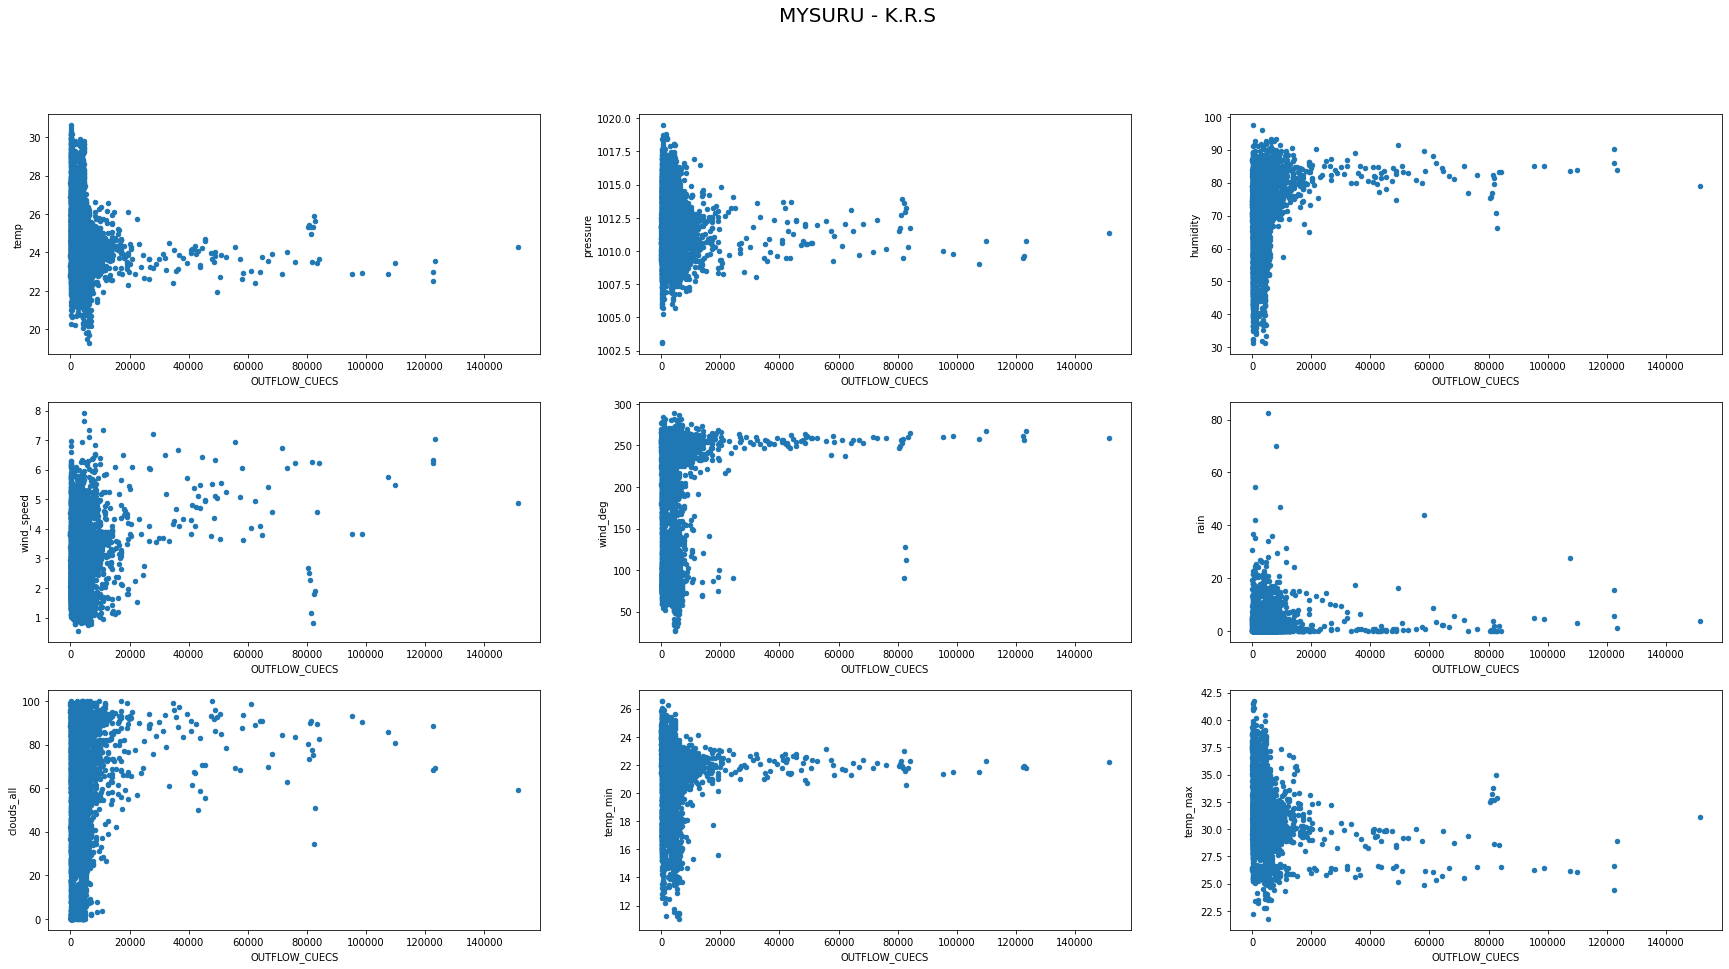

In [11]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(30, 15))
m.plot(x='OUTFLOW_CUECS', y='temp', kind='scatter', ax=ax[0][0], subplots=True)
m.plot(x='OUTFLOW_CUECS', y='pressure', kind='scatter', ax=ax[0][1], subplots=True)
m.plot(x='OUTFLOW_CUECS', y='humidity', kind='scatter', ax=ax[0][2], subplots=True)
m.plot(x='OUTFLOW_CUECS', y='wind_speed', kind='scatter', ax=ax[1][0], subplots=True)
m.plot(x='OUTFLOW_CUECS', y='wind_deg', kind='scatter', ax=ax[1][1], subplots=True)
m.plot(x='OUTFLOW_CUECS', y='rain', kind='scatter', ax=ax[1][2], subplots=True)
m.plot(x='OUTFLOW_CUECS', y='clouds_all', kind='scatter', ax=ax[2][0], subplots=True)
m.plot(x='OUTFLOW_CUECS', y='temp_min', kind='scatter', ax=ax[2][1], subplots=True)
m.plot(x='OUTFLOW_CUECS', y='temp_max', kind='scatter', ax=ax[2][2], subplots=True)
fig.suptitle('MYSURU - K.R.S', fontsize=20)
plt.show()

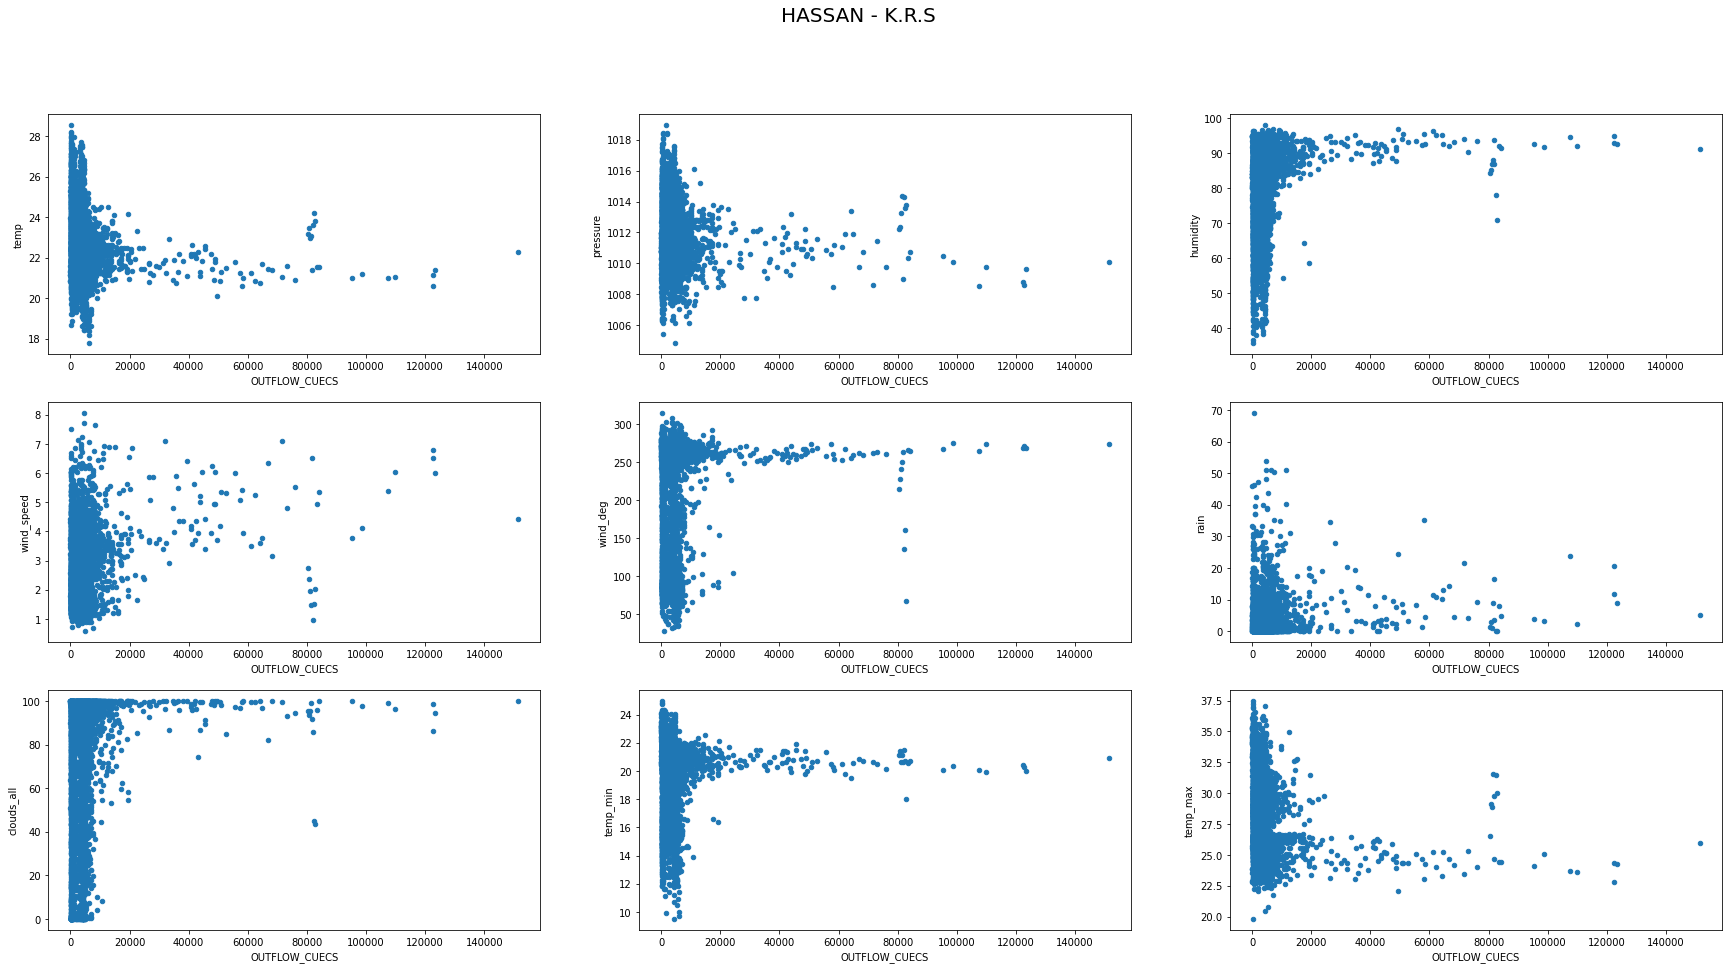

In [12]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(30, 15))
h.plot(x='OUTFLOW_CUECS', y='temp', kind='scatter', ax=ax[0][0], subplots=True)
h.plot(x='OUTFLOW_CUECS', y='pressure', kind='scatter', ax=ax[0][1], subplots=True)
h.plot(x='OUTFLOW_CUECS', y='humidity', kind='scatter', ax=ax[0][2], subplots=True)
h.plot(x='OUTFLOW_CUECS', y='wind_speed', kind='scatter', ax=ax[1][0], subplots=True)
h.plot(x='OUTFLOW_CUECS', y='wind_deg', kind='scatter', ax=ax[1][1], subplots=True)
h.plot(x='OUTFLOW_CUECS', y='rain', kind='scatter', ax=ax[1][2], subplots=True)
h.plot(x='OUTFLOW_CUECS', y='clouds_all', kind='scatter', ax=ax[2][0], subplots=True)
h.plot(x='OUTFLOW_CUECS', y='temp_min', kind='scatter', ax=ax[2][1], subplots=True)
h.plot(x='OUTFLOW_CUECS', y='temp_max', kind='scatter', ax=ax[2][2], subplots=True)
fig.suptitle('HASSAN - K.R.S', fontsize=20)
plt.show()

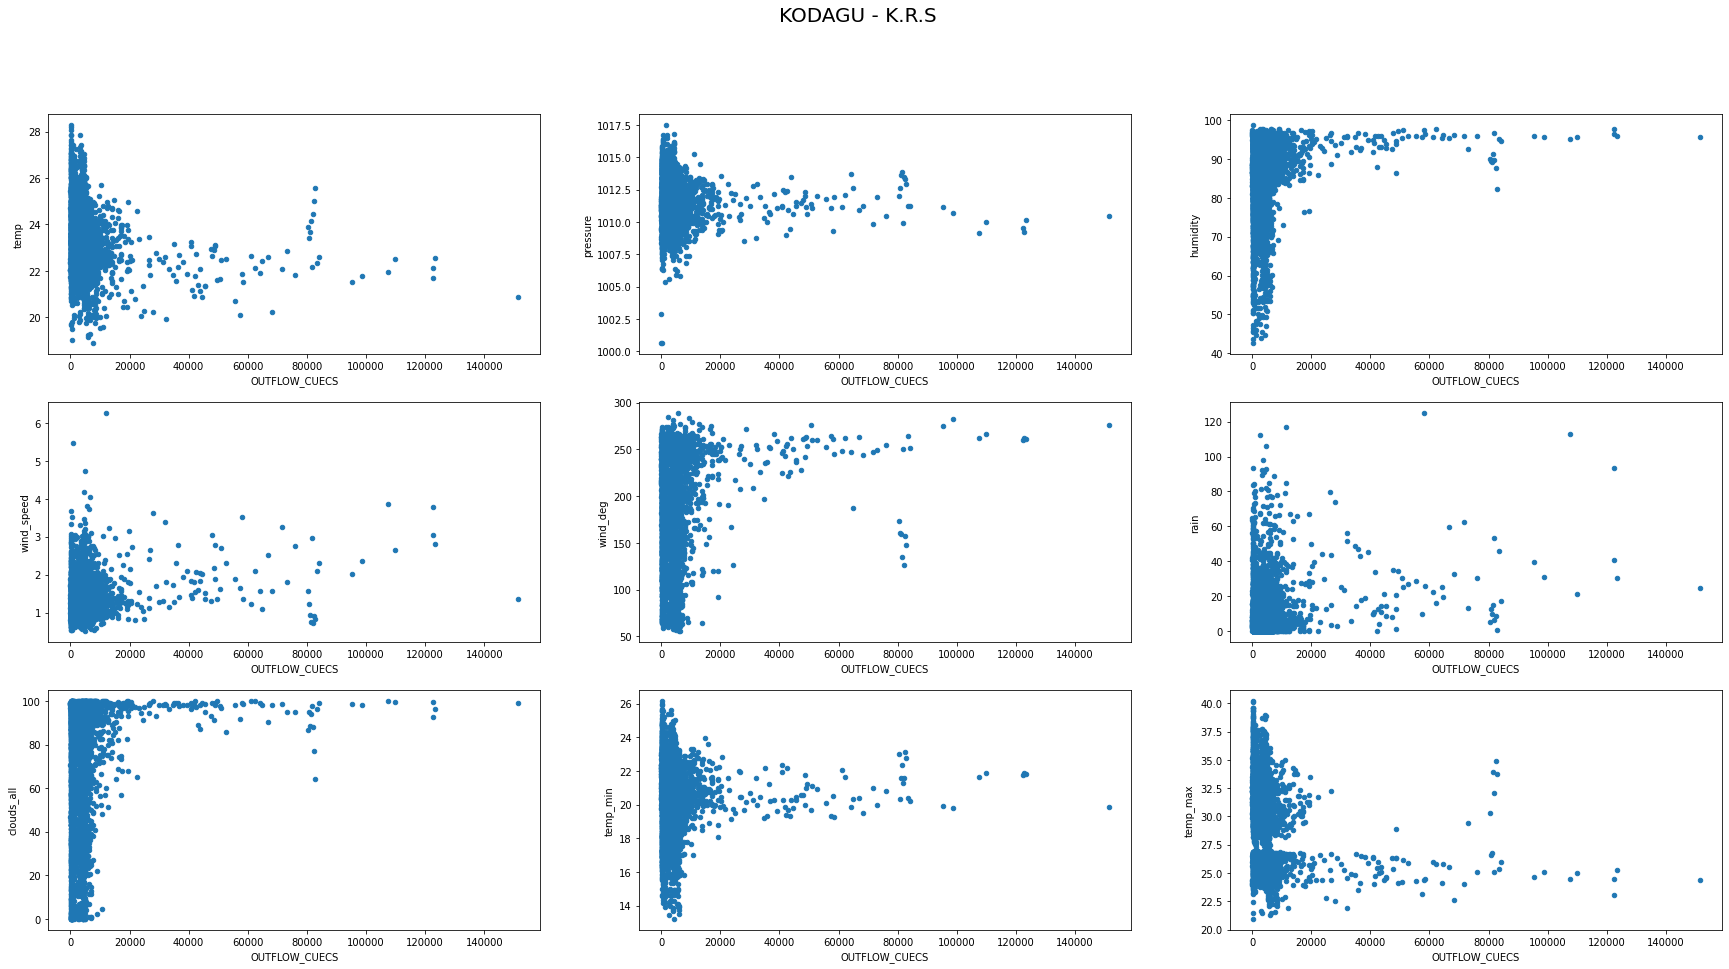

In [13]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(30, 15))
k.plot(x='OUTFLOW_CUECS', y='temp', kind='scatter', ax=ax[0][0], subplots=True)
k.plot(x='OUTFLOW_CUECS', y='pressure', kind='scatter', ax=ax[0][1], subplots=True)
k.plot(x='OUTFLOW_CUECS', y='humidity', kind='scatter', ax=ax[0][2], subplots=True)
k.plot(x='OUTFLOW_CUECS', y='wind_speed', kind='scatter', ax=ax[1][0], subplots=True)
k.plot(x='OUTFLOW_CUECS', y='wind_deg', kind='scatter', ax=ax[1][1], subplots=True)
k.plot(x='OUTFLOW_CUECS', y='rain', kind='scatter', ax=ax[1][2], subplots=True)
k.plot(x='OUTFLOW_CUECS', y='clouds_all', kind='scatter', ax=ax[2][0], subplots=True)
k.plot(x='OUTFLOW_CUECS', y='temp_min', kind='scatter', ax=ax[2][1], subplots=True)
k.plot(x='OUTFLOW_CUECS', y='temp_max', kind='scatter', ax=ax[2][2], subplots=True)
fig.suptitle('KODAGU - K.R.S', fontsize=20)
plt.show()

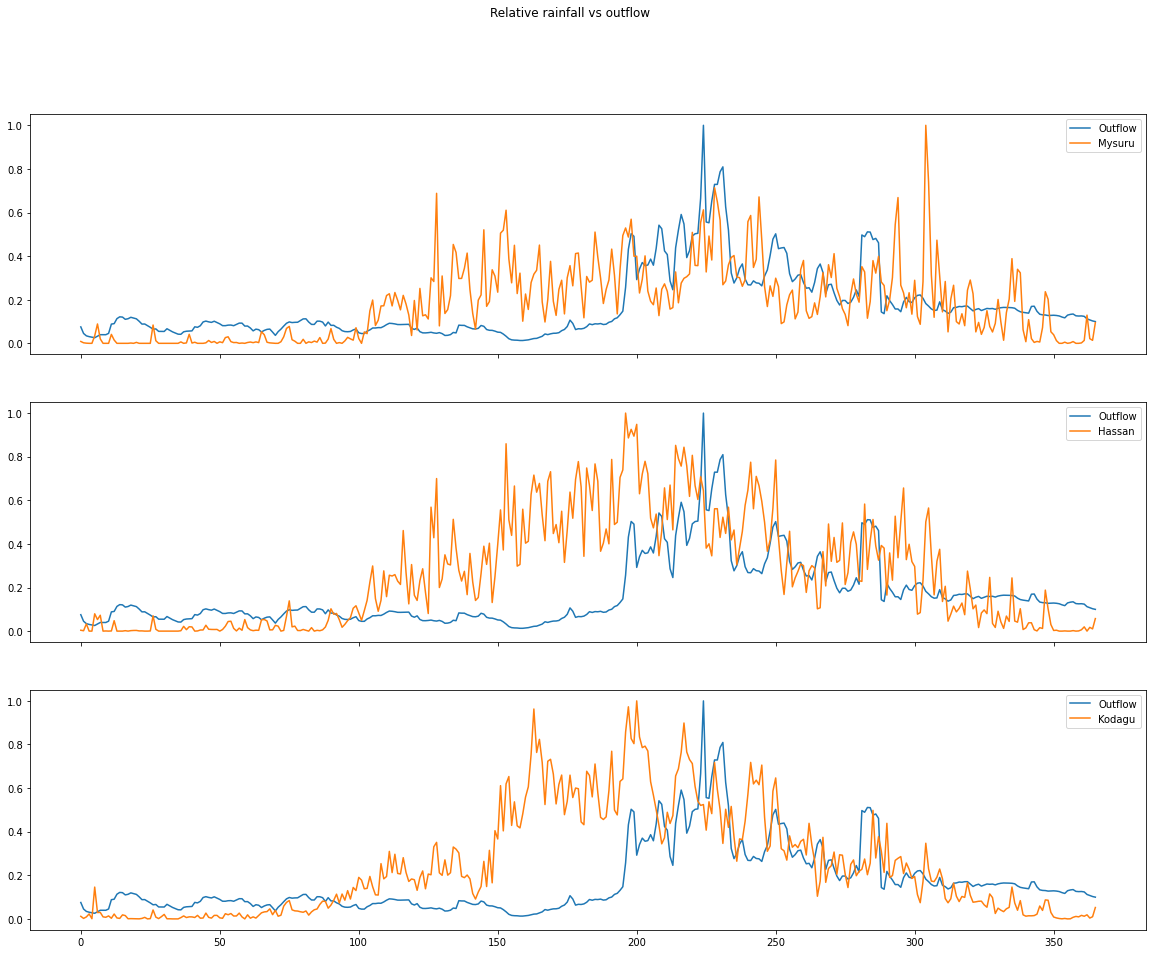

In [14]:
m.rename(columns={'rain': 'mysuru_rain'}, inplace=True)
h.rename(columns={'rain': 'hassan_rain'}, inplace=True)
k.rename(columns={'rain': 'kodagu_rain'}, inplace=True)
t = m[['YYYY', 'DD', 'MM', 'OUTFLOW_CUECS', 'mysuru_rain']].merge(h[['YYYY', 'DD', 'MM', 'OUTFLOW_CUECS', 'hassan_rain']], on=['YYYY', 'DD', 'MM', 'OUTFLOW_CUECS'], how='inner').merge(k[['YYYY', 'DD', 'MM', 'OUTFLOW_CUECS', 'kodagu_rain']], on=['YYYY', 'DD', 'MM', 'OUTFLOW_CUECS'], how='inner')
g = t.groupby(['MM', 'DD'])[['OUTFLOW_CUECS', 'mysuru_rain', 'hassan_rain', 'kodagu_rain']].mean()

fig, ax = plt.subplots(nrows=3, sharex=True, figsize=(20, 15))
ax[0].plot(range(g.shape[0]), g['OUTFLOW_CUECS'].values / g['OUTFLOW_CUECS'].max(), label='Outflow')
ax[0].plot(range(g.shape[0]), g['mysuru_rain'].values / g['mysuru_rain'].max(), label='Mysuru')
ax[1].plot(range(g.shape[0]), g['OUTFLOW_CUECS'].values / g['OUTFLOW_CUECS'].max(), label='Outflow')
ax[1].plot(range(g.shape[0]), g['hassan_rain'].values / g['hassan_rain'].max(), label='Hassan')
ax[2].plot(range(g.shape[0]), g['OUTFLOW_CUECS'].values / g['OUTFLOW_CUECS'].max(), label='Outflow')
ax[2].plot(range(g.shape[0]), g['kodagu_rain'].values / g['kodagu_rain'].max(), label='Kodagu')
ax[0].legend()
ax[1].legend()
ax[2].legend()
fig.suptitle('Relative rainfall vs outflow')
plt.show()

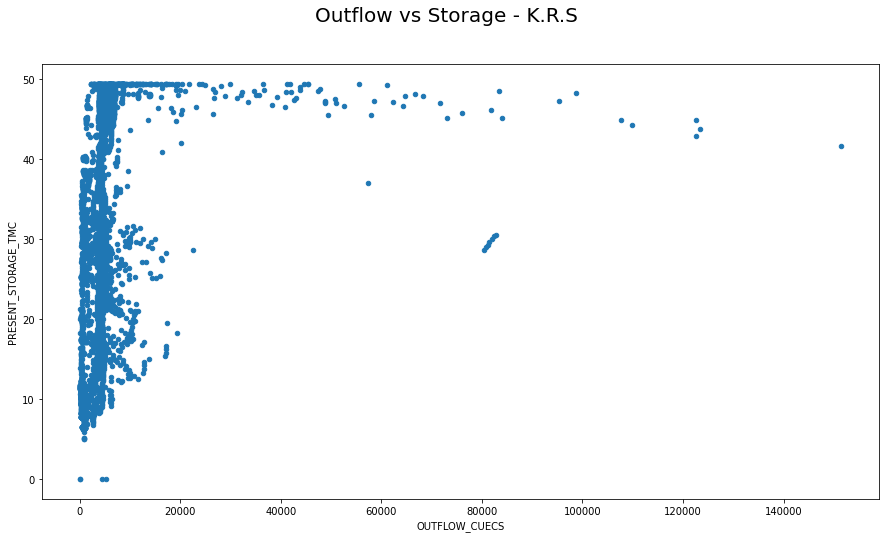

In [15]:
fig, ax = plt.subplots(figsize=(15, 8))
inflow_df.plot(x='OUTFLOW_CUECS', y='PRESENT_STORAGE_TMC', kind='scatter', ax=ax, subplots=True)
fig.suptitle('Outflow vs Storage - K.R.S', fontsize=20)
plt.show()

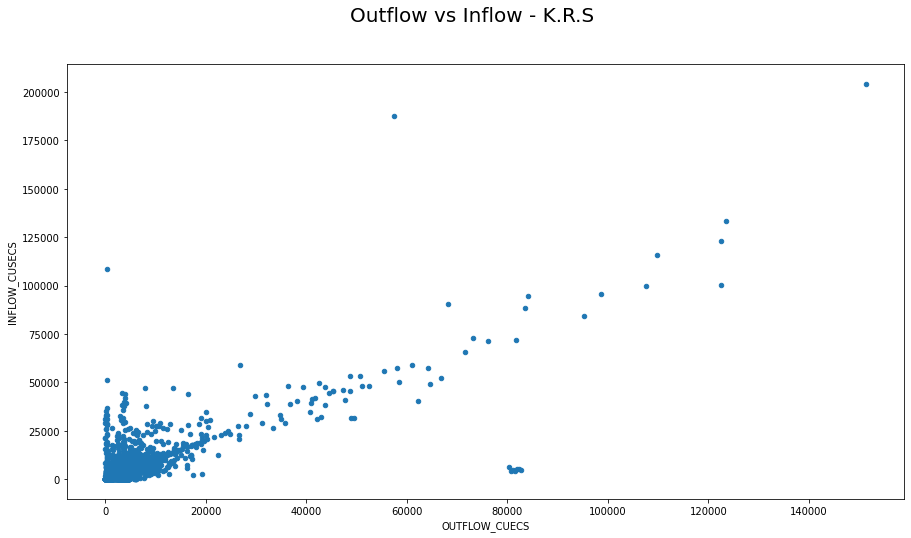

In [16]:
fig, ax = plt.subplots(figsize=(15, 8))
inflow_df.plot(x='OUTFLOW_CUECS', y='INFLOW_CUSECS', kind='scatter', ax=ax, subplots=True)
fig.suptitle('Outflow vs Inflow - K.R.S', fontsize=20)
plt.show()

In [17]:
inflow_df['OUTFLOW_CUECS'].describe([0.98, 0.99])

count      3308.000000
mean       4844.531439
std        9505.895497
min           0.000000
50%        3705.500000
98%       26828.600000
99%       50635.330000
max      151365.000000
Name: OUTFLOW_CUECS, dtype: float64

In [18]:
inflow_df = inflow_df[inflow_df['OUTFLOW_CUECS'] <= 50635.33]

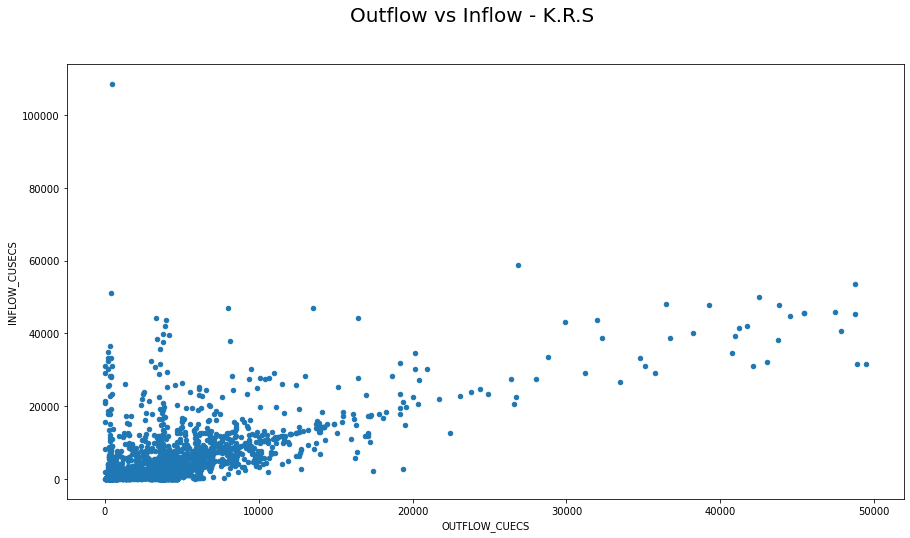

In [19]:
fig, ax = plt.subplots(figsize=(15, 8))
inflow_df.plot(x='OUTFLOW_CUECS', y='INFLOW_CUSECS', kind='scatter', ax=ax, subplots=True)
fig.suptitle('Outflow vs Inflow - K.R.S', fontsize=20)
plt.show()

### Dataset Transformation

In [20]:
inflow_df = inflow_df[['INFLOW_CUSECS', 'OUTFLOW_CUECS', 'YEAR', 'MONTH', 'DATE', 'SEASON']]
inflow_df.head()

,INFLOW_CUSECS,OUTFLOW_CUECS,YEAR,MONTH,DATE,SEASON
27,2029.0,2000.0,2011,1,1,WINTER
28,4924.0,2488.0,2012,1,1,WINTER
29,1885.0,1994.0,2014,1,1,WINTER
30,1631.0,4419.0,2015,1,1,WINTER
31,703.0,1965.0,2016,1,1,WINTER


In [21]:
with open('encoders/month_le.pkl', 'rb') as f:
    month_le = pickle.load(f)

with open('encoders/date_le.pkl', 'rb') as f:
    date_le = pickle.load(f)

with open('encoders/season_le.pkl', 'rb') as f:
    season_le = pickle.load(f)

In [22]:
rs_outflow = RobustScaler().fit(inflow_df[['OUTFLOW_CUECS']])

with open('encoders/rs_inflow.pkl', 'rb') as f:
    rs_inflow = pickle.load(f)

with open('encoders/rs_temp.pkl', 'rb') as f:
    rs_temp = pickle.load(f)

with open('encoders/rs_feels_like.pkl', 'rb') as f:
    rs_feels_like = pickle.load(f)

with open('encoders/rs_temp_min.pkl', 'rb') as f:
    rs_temp_min = pickle.load(f)

with open('encoders/rs_temp_max.pkl', 'rb') as f:
    rs_temp_max = pickle.load(f)

with open('encoders/rs_pressure.pkl', 'rb') as f:
    rs_pressure = pickle.load(f)

with open('encoders/rs_humidity.pkl', 'rb') as f:
    rs_humidity = pickle.load(f)

with open('encoders/rs_wind_speed.pkl', 'rb') as f:
    rs_wind_speed = pickle.load(f)

with open('encoders/rs_wind_deg.pkl', 'rb') as f:
    rs_wind_deg = pickle.load(f)

with open('encoders/rs_rain.pkl', 'rb') as f:
    rs_rain = pickle.load(f)

with open('encoders/rs_clouds_all.pkl', 'rb') as f:
    rs_clouds_all = pickle.load(f)

# remaining columns will be divided by 24 for scaling purpose.

In [23]:
inflow_df['INFLOW_CUSECS'] = rs_inflow.transform(inflow_df[['INFLOW_CUSECS']]).flatten()
inflow_df['OUTFLOW_CUECS'] = rs_outflow.transform(inflow_df[['OUTFLOW_CUECS']]).flatten()
inflow_df.head()

/home/santanu/python-all/lib/python3.7/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)
/home/santanu/python-all/lib/python3.7/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


,INFLOW_CUSECS,OUTFLOW_CUECS,YEAR,MONTH,DATE,SEASON
27,0.073551,-0.379450,2011,1,1,WINTER
28,0.665848,-0.268269,2012,1,1,WINTER
29,0.044090,-0.380817,2014,1,1,WINTER
30,-0.007877,0.171669,2015,1,1,WINTER
31,-0.197739,-0.387424,2016,1,1,WINTER


In [24]:
inflow_df['date'] = pd.to_datetime(inflow_df['YEAR'].astype(str) + '-' + inflow_df['MONTH'].astype(str) + '-' + inflow_df['DATE'].astype(str))
inflow_df.head()

/home/santanu/python-all/lib/python3.7/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


,INFLOW_CUSECS,OUTFLOW_CUECS,YEAR,MONTH,DATE,SEASON,date
27,0.073551,-0.379450,2011,1,1,WINTER,2011-01-01
28,0.665848,-0.268269,2012,1,1,WINTER,2012-01-01
29,0.044090,-0.380817,2014,1,1,WINTER,2014-01-01
30,-0.007877,0.171669,2015,1,1,WINTER,2015-01-01
31,-0.197739,-0.387424,2016,1,1,WINTER,2016-01-01


In [25]:
weather_df.columns

Index(['date', 'city_name', 'temp', 'feels_like', 'temp_min', 'temp_max',
       'pressure', 'humidity', 'wind_speed', 'wind_deg', 'rain', 'clouds_all',
       'broken clouds', 'overcast clouds', 'scattered clouds', 'sky is clear',
       'few clouds', 'fog', 'light rain', 'mist', 'haze', 'moderate rain',
       'heavy intensity rain', 'light intensity drizzle', 'drizzle',
       'heavy intensity drizzle', 'very heavy rain',
       'thunderstorm with heavy rain', 'thunderstorm with rain',
       'thunderstorm', 'proximity shower rain', 'thunderstorm with light rain',
       'shower rain', 'light intensity shower rain', 'light thunderstorm',
       'YYYY', 'MM', 'DD'],
      dtype='object')

In [26]:
weather_df['temp'] = rs_temp.transform(weather_df[['temp']]).flatten()
weather_df['feels_like'] = rs_feels_like.transform(weather_df[['feels_like']]).flatten()
weather_df['temp_min'] = rs_temp_min.transform(weather_df[['temp_min']]).flatten()
weather_df['temp_max'] = rs_temp_max.transform(weather_df[['temp_max']]).flatten()
weather_df['pressure'] = rs_pressure.transform(weather_df[['pressure']]).flatten()
weather_df['humidity'] = rs_humidity.transform(weather_df[['humidity']]).flatten()
weather_df['wind_speed'] = rs_wind_speed.transform(weather_df[['wind_speed']]).flatten()
weather_df['wind_deg'] = rs_wind_deg.transform(weather_df[['wind_deg']]).flatten()
weather_df['rain'] = rs_rain.transform(weather_df[['rain']]).flatten()
weather_df['clouds_all'] = rs_clouds_all.transform(weather_df[['clouds_all']]).flatten()
weather_df.loc[:, ('broken clouds', 'overcast clouds', 'scattered clouds', 'sky is clear',
       'few clouds', 'fog', 'light rain', 'mist', 'haze', 'moderate rain',
       'heavy intensity rain', 'light intensity drizzle', 'drizzle',
       'heavy intensity drizzle', 'very heavy rain',
       'thunderstorm with heavy rain', 'thunderstorm with rain',
       'thunderstorm', 'proximity shower rain', 'thunderstorm with light rain',
       'shower rain', 'light intensity shower rain', 'light thunderstorm')] = weather_df.loc[:, ('broken clouds', 'overcast clouds', 'scattered clouds', 'sky is clear',
       'few clouds', 'fog', 'light rain', 'mist', 'haze', 'moderate rain',
       'heavy intensity rain', 'light intensity drizzle', 'drizzle',
       'heavy intensity drizzle', 'very heavy rain',
       'thunderstorm with heavy rain', 'thunderstorm with rain',
       'thunderstorm', 'proximity shower rain', 'thunderstorm with light rain',
       'shower rain', 'light intensity shower rain', 'light thunderstorm')] / 24

In [27]:
weather_df.head()

,date,city_name,temp,feels_like,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,...,thunderstorm with rain,thunderstorm,proximity shower rain,thunderstorm with light rain,shower rain,light intensity shower rain,light thunderstorm,YYYY,MM,DD
0,2010-01-01,Hassan,-0.736,-0.737201,-1.281690,-0.657143,0.683274,-0.156784,0.559748,-0.826564,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2010,1,1
1,2010-01-01,Kodagu,0.116,0.180887,-0.281690,0.242857,0.209964,0.161345,-0.232704,-0.714651,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2010,1,1
2,2010-01-01,Mysuru,0.228,0.112628,-0.718310,0.048214,0.476868,-0.698404,0.440252,-0.818667,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2010,1,1
3,2010-01-02,Hassan,-1.152,-1.153584,-2.250000,-0.478571,1.306050,-0.394527,0.314465,-0.969765,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2010,1,2
4,2010-01-02,Kodagu,-0.020,0.078498,-0.591549,0.330357,0.889680,-0.130559,-0.320755,-0.652602,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2010,1,2


In [28]:
kodagu_df = weather_df[weather_df['city_name'] == 'Kodagu'].reset_index(drop=True)
hassan_df = weather_df[weather_df['city_name'] == 'Hassan'].reset_index(drop=True)
mysuru_df = weather_df[weather_df['city_name'] == 'Mysuru'].reset_index(drop=True)

In [29]:
train_inflow_df = inflow_df[inflow_df['YEAR'] < 2020].reset_index(drop=True)
val_inflow_df = inflow_df[inflow_df['YEAR'] == 2020].reset_index(drop=True)

train_inflow_df.shape, val_inflow_df.shape

((2944, 7), (330, 7))

In [30]:
def embed_day(df):
    data = {}
    for index in tqdm(df.index):
        row = df.iloc[index]
        inflow = row['INFLOW_CUSECS']
        outflow = row['OUTFLOW_CUECS']
        year = row['YEAR']
        month = row['MONTH']
        date = row['DATE']
        season = row['SEASON']

        ddmmyyyy = datetime.date(year, month, date)
        ddmmyyyy_list = [str(ddmmyyyy + timedelta(days=day)) for day in range(-10, 1)]

        # sel_kodagu = kodagu_df[kodagu_df['date'].isin(ddmmyyyy_list)].drop(columns=['date', 'city_name', 'YYYY', 'MM', 'DD']).values.flatten()
        # sel_hassan = hassan_df[hassan_df['date'].isin(ddmmyyyy_list)].drop(columns=['date', 'city_name', 'YYYY', 'MM', 'DD']).values.flatten()
        sel_mysuru = mysuru_df[mysuru_df['date'].isin(ddmmyyyy_list)].drop(columns=['date', 'city_name', 'YYYY', 'MM', 'DD']).values.flatten()
        sel_inflow = inflow_df[inflow_df['date'].isin(ddmmyyyy_list)]['INFLOW_CUSECS'].values.flatten()
        
        if sel_inflow.shape[0] != len(ddmmyyyy_list):
            continue
        
        month_transformed = month_le.transform([month])
        date_transformed = date_le.transform([date])
        season_transformed = season_le.transform([season])
        
        data[ddmmyyyy] = np.concatenate([month_transformed, date_transformed, season_transformed, sel_mysuru, sel_inflow, [outflow]])
#         data[ddmmyyyy] = np.concatenate([month_transformed, date_transformed, season_transformed, sel_mysuru, sel_kodagu, sel_hassan, [inflow], [outflow]])
    return pd.DataFrame(data).T

In [31]:
train_emb_df = embed_day(train_inflow_df)
val_emb_df = embed_day(val_inflow_df)

In [32]:
train_emb_df.head()

,0,1,2,3,4,5,6,7,8,9,...,368,369,370,371,372,373,374,375,376,377
2012-01-01,0.0,0.0,2.0,-1.364,-1.412969,-2.186620,-0.591071,0.519573,-0.783922,0.283019,...,0.479055,0.675260,0.527339,0.499514,0.487239,0.516086,0.511585,0.451844,0.255230,-0.268269
2014-01-01,0.0,0.0,2.0,-0.500,-0.665529,-1.531690,-0.212500,0.903915,-1.092930,0.496855,...,0.139430,0.110992,0.005013,-0.018720,0.041635,0.064345,0.063731,0.042044,0.044090,-0.380817
2015-01-01,0.0,0.0,2.0,0.284,0.170648,-0.211268,0.273214,0.252669,-0.705815,0.006289,...,0.392921,0.399877,0.370825,0.340545,0.451639,0.336658,0.251547,0.164186,0.164186,0.171669
2016-01-01,0.0,0.0,2.0,-0.320,-0.436860,-1.348592,0.008929,1.765125,-0.732041,-0.069182,...,-0.123063,-0.222904,-0.179735,-0.157844,-0.179940,-0.137793,-0.050841,-0.085827,-0.129610,-0.387424
2017-01-01,0.0,0.0,2.0,0.076,-0.215017,-1.482394,-0.076786,1.291815,-1.515964,-0.176101,...,-0.225973,-0.236407,-0.225973,-0.236407,-0.246637,-0.267096,-0.277326,-0.267096,-0.277326,-0.777240


In [33]:
X_train, y_train = train_emb_df.values[:, :-1], train_emb_df.values[:, -1]
X_val, y_val = val_emb_df.values[:, :-1], val_emb_df.values[:, -1]
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((2788, 377), (2788,), (310, 377), (310,))

### Model Training

In [34]:
%%time
model = XGBRegressor(n_estimators=120,
                     learning_rate=0.05,
                     max_depth=5,
                     random_state=0)
model.fit(X_train, y_train,
          eval_set=[(X_train, y_train), (X_val, y_val)],
          verbose=True)

/home/santanu/python-all/lib/python3.7/site-packages/xgboost/data.py:121: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


[0]	validation_0-rmse:0.97679	validation_1-rmse:1.09326
[1]	validation_0-rmse:0.94476	validation_1-rmse:1.06735
[2]	validation_0-rmse:0.91475	validation_1-rmse:1.04204
[3]	validation_0-rmse:0.88651	validation_1-rmse:1.01943
[4]	validation_0-rmse:0.85987	validation_1-rmse:1.00101
[5]	validation_0-rmse:0.83419	validation_1-rmse:0.98286
[6]	validation_0-rmse:0.80837	validation_1-rmse:0.95469
[7]	validation_0-rmse:0.78569	validation_1-rmse:0.94045
[8]	validation_0-rmse:0.76390	validation_1-rmse:0.91938
[9]	validation_0-rmse:0.74369	validation_1-rmse:0.90847
[10]	validation_0-rmse:0.72246	validation_1-rmse:0.88361
[11]	validation_0-rmse:0.70251	validation_1-rmse:0.86295
[12]	validation_0-rmse:0.68385	validation_1-rmse:0.84334
[13]	validation_0-rmse:0.66528	validation_1-rmse:0.82419
[14]	validation_0-rmse:0.64846	validation_1-rmse:0.80447
[15]	validation_0-rmse:0.63197	validation_1-rmse:0.78033
[16]	validation_0-rmse:0.61680	validation_1-rmse:0.76262
[17]	validation_0-rmse:0.60311	validation

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.05, max_delta_step=0, max_depth=5,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=120, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [35]:
# model = GradientBoostingRegressor(max_depth=10, random_state=0)
# model.fit(X_train, y_train)
#[132]	validation_0-rmse:0.02216	validation_1-rmse:0.47950

In [36]:
# model = RandomForestRegressor(max_depth=10, random_state=0)
# model.fit(X_train, y_train)

In [38]:
# model = SVR(degree=10)
# model.fit(X_train, y_train)

In [39]:
train_predictions = model.predict(X_train)
print("Train R2 score:", r2_score(y_train, train_predictions))
test_predictions = model.predict(X_val)
print("Test R2 score:", r2_score(y_val, test_predictions))

Train R2 score: 0.9017696157049899
Test R2 score: 0.6874123366191291


### Predict and check Loss

In [40]:
y_pred_train = model.predict(X_train)
y_pred_train = rs_outflow.inverse_transform(y_pred_train.reshape(-1, 1)).flatten()
y_train_inv_trf = rs_outflow.inverse_transform(y_train.reshape(-1, 1)).flatten()
loss = mean_squared_error(y_train_inv_trf, y_pred_train)
loss

1492922.1895236475

In [41]:
y_pred_test = model.predict(X_val)
y_pred_test = rs_outflow.inverse_transform(y_pred_test.reshape(-1, 1)).flatten()
y_val_inv_trf = rs_outflow.inverse_transform(y_val.reshape(-1, 1)).flatten()
loss = mean_squared_error(y_val_inv_trf, y_pred_test)
loss

6501642.579503507

### Compare Prediction on Test data

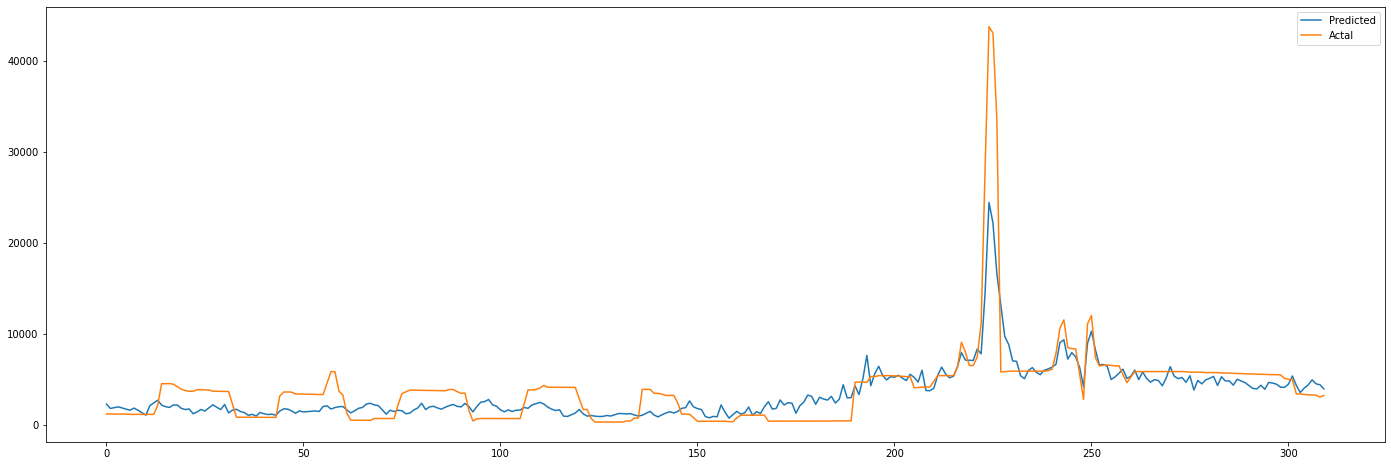

In [42]:
plt.figure(figsize=(24,8))
plt.plot(y_pred_test, label='Predicted')
plt.plot(y_val_inv_trf, label='Actal')
plt.legend()
plt.show()

### Compare Prediction on Entire data

In [43]:
model_pred_df = pd.concat([train_emb_df, val_emb_df])
model_pred_df['Predicted_Outflow'] = np.concatenate([y_pred_train, y_pred_test])
model_pred_df['OUTFLOW_CUECS'] = np.concatenate([y_train_inv_trf, y_val_inv_trf])
model_pred_df.reset_index(inplace=True)
model_pred_df['index'] = pd.to_datetime(model_pred_df['index'])
model_pred_df['MONTH'] = model_pred_df['index'].dt.month
model_pred_df['DATE'] = model_pred_df['index'].dt.day
model_pred_df['YEAR'] = model_pred_df['index'].dt.year
model_pred_df

,index,0,1,2,3,4,5,6,7,8,...,373,374,375,376,377,Predicted_Outflow,OUTFLOW_CUECS,MONTH,DATE,YEAR
0,2012-01-01,0.0,0.0,2.0,-1.364,-1.412969,-2.186620,-0.591071,0.519573,-0.783922,...,0.516086,0.511585,0.451844,0.255230,-0.268269,3462.042236,2488.0,1,1,2012
1,2014-01-01,0.0,0.0,2.0,-0.500,-0.665529,-1.531690,-0.212500,0.903915,-1.092930,...,0.064345,0.063731,0.042044,0.044090,-0.380817,2298.128662,1994.0,1,1,2014
2,2015-01-01,0.0,0.0,2.0,0.284,0.170648,-0.211268,0.273214,0.252669,-0.705815,...,0.336658,0.251547,0.164186,0.164186,0.171669,2803.906006,4419.0,1,1,2015
3,2016-01-01,0.0,0.0,2.0,-0.320,-0.436860,-1.348592,0.008929,1.765125,-0.732041,...,-0.137793,-0.050841,-0.085827,-0.129610,-0.387424,1498.285400,1965.0,1,1,2016
4,2017-01-01,0.0,0.0,2.0,0.076,-0.215017,-1.482394,-0.076786,1.291815,-1.515964,...,-0.267096,-0.277326,-0.267096,-0.277326,-0.777240,978.347412,254.0,1,1,2017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3093,2020-12-12,11.0,11.0,2.0,-0.316,-0.416382,-0.866197,-0.369643,0.875445,-0.753136,...,0.394149,0.394149,0.383919,0.373689,-0.081449,4385.434570,3308.0,12,12,2020
3094,2020-12-13,11.0,12.0,2.0,-0.988,-0.907850,-0.126761,-1.162500,0.637011,0.240593,...,0.394149,0.383919,0.373689,0.312516,-0.083272,4955.337891,3300.0,12,13,2020
3095,2020-12-14,11.0,13.0,2.0,-0.800,-0.720137,0.010563,-1.137500,0.291815,0.308438,...,0.383919,0.373689,0.312516,0.277531,-0.089423,4519.594238,3273.0,12,14,2020
3096,2020-12-15,11.0,14.0,2.0,-0.460,-0.399317,0.165493,-0.853571,0.402135,0.315849,...,0.373689,0.312516,0.277531,0.176052,-0.136128,4421.044434,3068.0,12,15,2020


In [44]:
avg_daily_pred_outflow = model_pred_df.groupby(['MONTH', 'DATE'])['Predicted_Outflow'].mean().values
avg_daily_actual_outflow = model_pred_df.groupby(['MONTH', 'DATE'])['OUTFLOW_CUECS'].mean().values

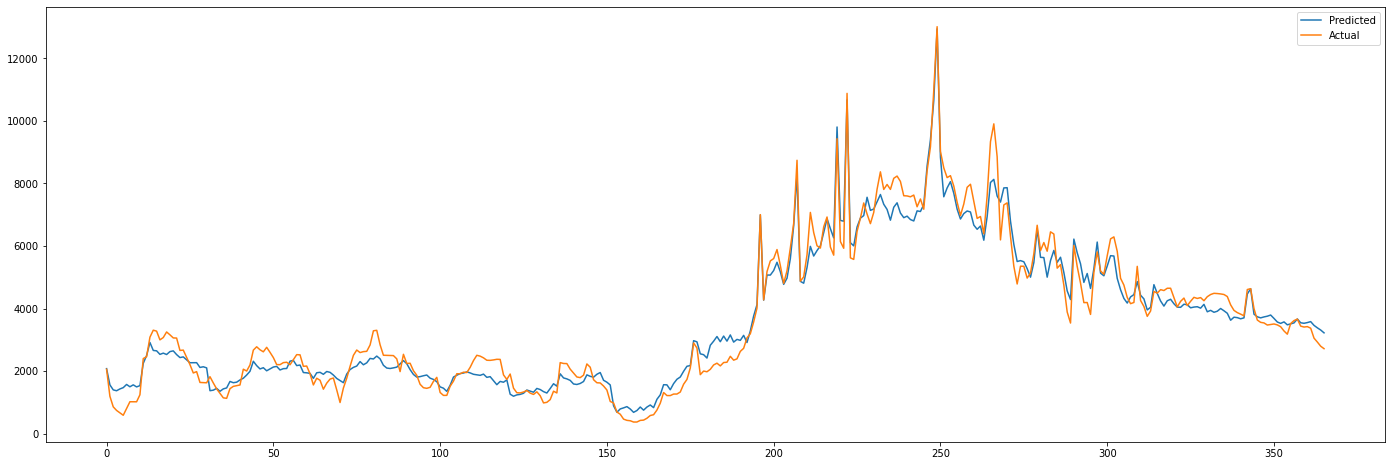

In [45]:
plt.figure(figsize=(24, 8))
plt.plot(avg_daily_pred_outflow, label='Predicted')
plt.plot(avg_daily_actual_outflow, label='Actual')
plt.legend()
# ax2.plot(avg_daily_actual_rainfall, label='Actual')
plt.show()

In [46]:
model_pred_df.sort_values(by=['YEAR', 'MONTH', 'DATE'], inplace=True)

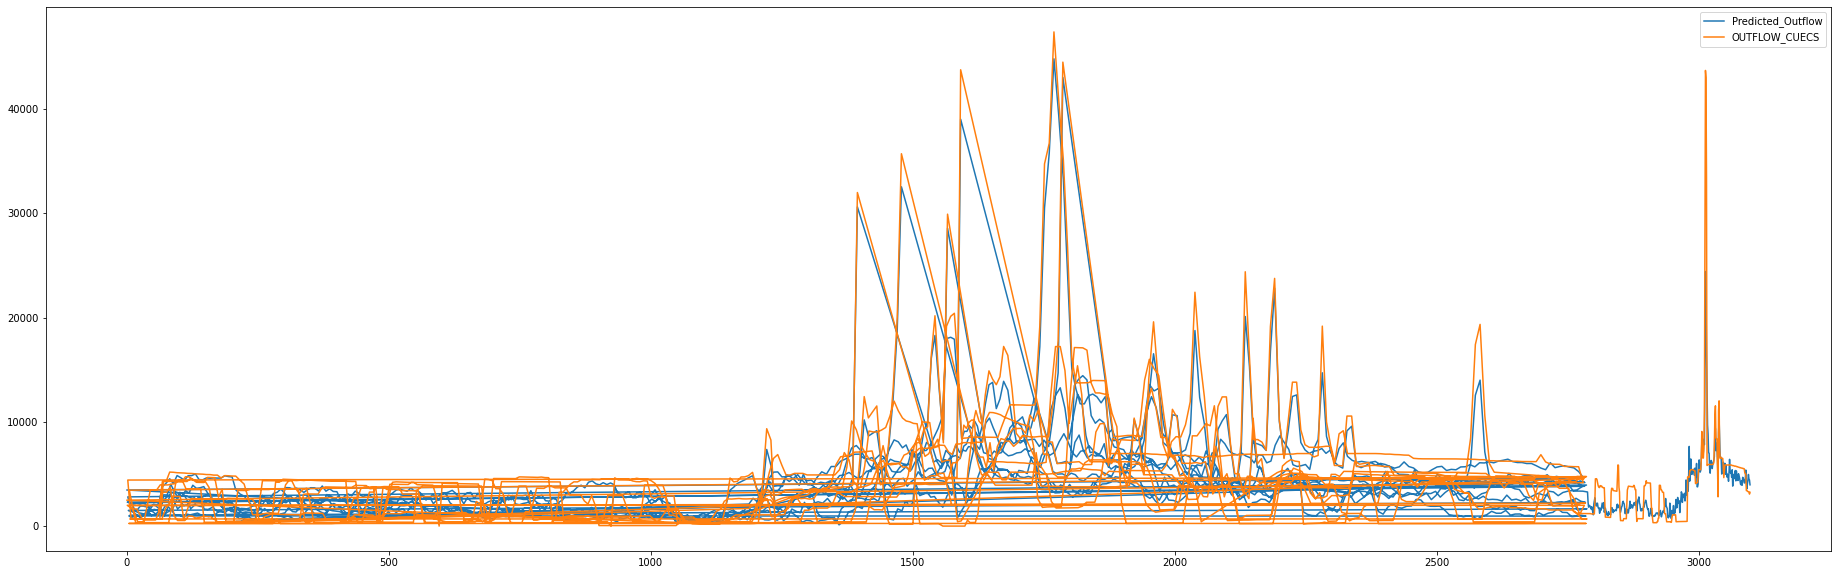

In [74]:
plt.figure(figsize=(32, 10))
model_pred_df['Predicted_Outflow'].plot()
model_pred_df['OUTFLOW_CUECS'].plot()
plt.legend()
plt.show()

In [75]:
((y_train_inv_trf - y_pred_train) ** 2).mean() ** .5

1221.851958115615

In [76]:
((y_val_inv_trf - y_pred_test) ** 2).mean() ** .5

2549.831921497174

### Check Feature Importance

In [ ]:
feature_list = [['Month', 'Date', 'Season']] + [[f'{day_region}_temp', f'{day_region}_feels_like', f'{day_region}_temp_min', f'{day_region}_temp_max', f'{day_region}_pressure', f'{day_region}_humidity',
                                                 f'{day_region}_wind_speed', f'{day_region}_wind_deg', f'{day_region}_rain', f'{day_region}_clouds_all', f'{day_region}_broken clouds', f'{day_region}_overcast clouds',
                                                 f'{day_region}_scattered clouds', f'{day_region}_sky is clear', f'{day_region}_few clouds', f'{day_region}_fog', f'{day_region}_light rain', f'{day_region}_mist',
                                                 f'{day_region}_haze', f'{day_region}_moderate rain', f'{day_region}_heavy intensity rain', f'{day_region}_light intensity drizzle', f'{day_region}_drizzle',
                                                 f'{day_region}_heavy intensity drizzle', f'{day_region}_very heavy rain', f'{day_region}_thunderstorm with heavy rain', f'{day_region}_thunderstorm with rain',
                                                 f'{day_region}_thunderstorm', f'{day_region}_proximity shower rain', f'{day_region}_thunderstorm with light rain', f'{day_region}_shower rain',
                                                 f'{day_region}_light intensity shower rain', f'{day_region}_light thunderstorm'] for day_region in ['1_mysuru', '2_mysuru', '1_kodagu', '2_kodagu', '1_hassan', '2_hassan']]
feature_list = feature_list[0] + feature_list[1] + feature_list[2] + ['Inflow']#feature_list[3] + feature_list[4] + feature_list[5] + feature_list[6]
len(feature_list)

70

In [ ]:
feature_list

['Month',
 'Date',
 'Season',
 '1_mysuru_temp',
 '1_mysuru_feels_like',
 '1_mysuru_temp_min',
 '1_mysuru_temp_max',
 '1_mysuru_pressure',
 '1_mysuru_humidity',
 '1_mysuru_wind_speed',
 '1_mysuru_wind_deg',
 '1_mysuru_rain',
 '1_mysuru_clouds_all',
 '1_mysuru_broken clouds',
 '1_mysuru_overcast clouds',
 '1_mysuru_scattered clouds',
 '1_mysuru_sky is clear',
 '1_mysuru_few clouds',
 '1_mysuru_fog',
 '1_mysuru_light rain',
 '1_mysuru_mist',
 '1_mysuru_haze',
 '1_mysuru_moderate rain',
 '1_mysuru_heavy intensity rain',
 '1_mysuru_light intensity drizzle',
 '1_mysuru_drizzle',
 '1_mysuru_heavy intensity drizzle',
 '1_mysuru_very heavy rain',
 '1_mysuru_thunderstorm with heavy rain',
 '1_mysuru_thunderstorm with rain',
 '1_mysuru_thunderstorm',
 '1_mysuru_proximity shower rain',
 '1_mysuru_thunderstorm with light rain',
 '1_mysuru_shower rain',
 '1_mysuru_light intensity shower rain',
 '1_mysuru_light thunderstorm',
 '2_mysuru_temp',
 '2_mysuru_feels_like',
 '2_mysuru_temp_min',
 '2_mysuru_

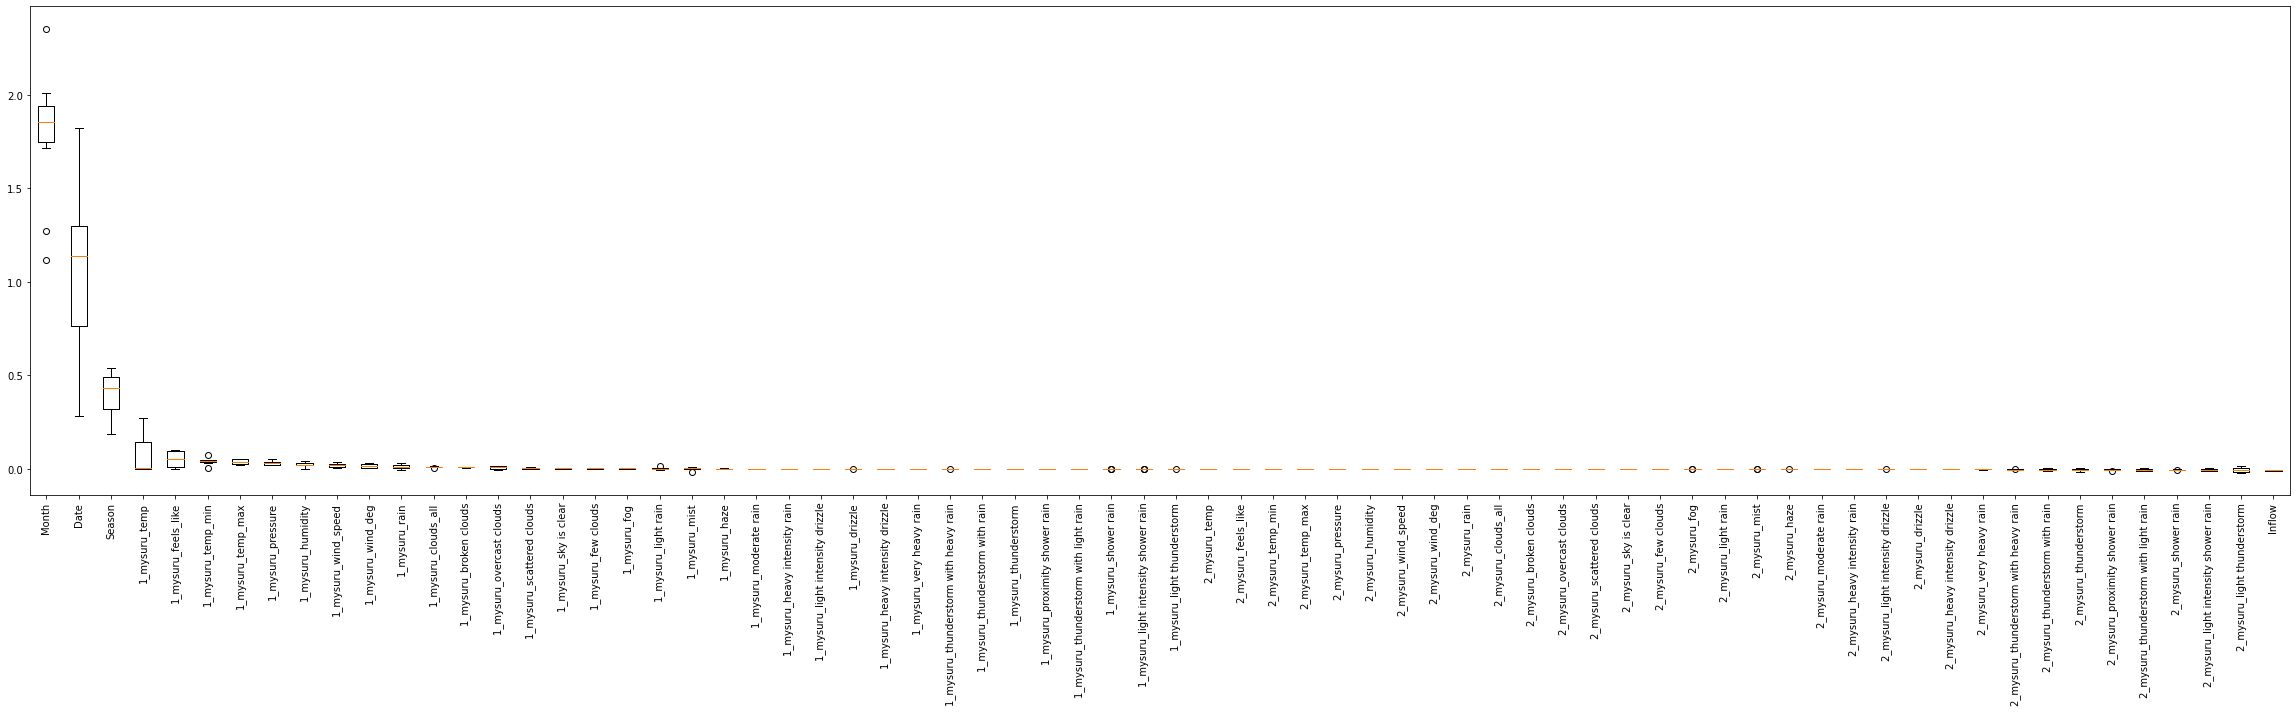

Season    : -0.008 +/- 0.002
2_mysuru_pressure: -0.006 +/- 0.012
2_mysuru_wind_speed: -0.005 +/- 0.006
2_mysuru_wind_deg: -0.004 +/- 0.002
2_mysuru_humidity: -0.004 +/- 0.005
1_mysuru_wind_deg: -0.004 +/- 0.003
2_mysuru_overcast clouds: -0.004 +/- 0.007
2_mysuru_scattered clouds: -0.004 +/- 0.003
1_mysuru_feels_like: -0.003 +/- 0.002
1_mysuru_scattered clouds: -0.001 +/- 0.001
1_mysuru_sky is clear: -0.001 +/- 0.001
2_mysuru_moderate rain: -0.000 +/- 0.000
1_mysuru_moderate rain: -0.000 +/- 0.000
1_mysuru_haze: -0.000 +/- 0.000
2_mysuru_light intensity drizzle: -0.000 +/- 0.000
1_mysuru_shower rain: -0.000 +/- 0.000
1_mysuru_heavy intensity rain: -0.000 +/- 0.000
1_mysuru_thunderstorm with light rain: -0.000 +/- 0.000
2_mysuru_thunderstorm with light rain: -0.000 +/- 0.000
2_mysuru_drizzle: 0.000 +/- 0.000
1_mysuru_proximity shower rain: 0.000 +/- 0.000
2_mysuru_proximity shower rain: 0.000 +/- 0.000
1_mysuru_thunderstorm with heavy rain: 0.000 +/- 0.000
1_mysuru_very heavy rain: 0.000

In [ ]:
r = permutation_importance(model, X_val, y_val,
                           n_repeats=10,
                           random_state=0)

sort_idx = r.importances_mean.argsort()[::-1]

plt.figure(figsize=(32, 10))
plt.boxplot(r.importances[sort_idx].T, labels=feature_list)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

for i in sort_idx[::-1]:
    print(f"{feature_list[i]:10s}: {r.importances_mean[i]:.3f} +/- "
          f"{r.importances_std[i]:.3f}")

### Save Model

In [47]:
with open('encoders/rs_outflow.pkl', 'wb') as f:
    pickle.dump(rs_outflow, f)

In [48]:
model.save_model("outflow_xgboost.json")